# Hyperparameters and lags search: backtesting vs one-step-ahead

Hyperparameter and lag tuning involves systematically testing different values or combinations of hyperparameters (and/or lags) to find the optimal configuration that gives the best performance. The **skforecast** library provides two different methods to evaluate each candidate configuration:

+ Backtesting: In this method, the model predicts several steps ahead in each iteration, using the same forecast horizon and retraining frequency strategy that would be used if the model were deployed. This simulates a real forecasting scenario where the model is retrained and updated over time.

+ One-Step Ahead: Evaluates the model using only one-step-ahead predictions. This method is faster because it requires fewer iterations, but it only tests the model's performance in the immediate next time step.

Each method uses a different evaluation strategy, so they may produce different results. However, in the long run, both methods are expected to converge to similar selections of optimal hyperparameters. The one-step-ahead method is much faster than backtesting because it requires fewer iterations, but it only tests the model's performance in the immediate next time step. It is recommended to backtest the final model for a more accurate multi-step performance estimate.

The document compares the performance of these two methods when applied to various datasets and forecaster types. The process is outlined as follows:

+ Optimal hyperparameters and lags are identified through a search using both backtesting and one-step-ahead evaluation methods.

+ This search is conducted on the validation partition, with the best configuration recorded, along with the time taken to complete the search.

+ Finally, the selected best configuration is evaluated on the test partition using a backtesting procedure.

It is important to note that the final evaluation is consistently performed using backtesting to simulate a real-world multi-step forecasting scenario.

## Results

The results show a significant reduction in the time required to find the optimal configuration using the one-step-ahead method (upper panel). However, the performance of the selected configuration on the test partition is similar for both methods (lower panel), with no clear winner. These findings are consistent across both grid search and Bayesian search approaches.

<div style="text-align: center;">
    <img src="../img/grid_search_benchmarck.png" alt="Grid Search Results" width="700"/>
</div>

<div style="text-align: center;">
    <img src="../img/bayesian_search_benchmarck.png" alt="Grid Search Results" width="700"/>
</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The purpose of this analysis is to compare the time and forecasting performance of the two available evaluation methods, not to compare different forecasters.

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import platform
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from copy import copy
import sklearn
import skforecast
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

# Warnings
# ==============================================================================
import warnings
from skforecast.exceptions import IgnoredArgumentWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', category=IgnoredArgumentWarning)

In [2]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"lightgbm version    : {lightgbm.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
#Computer network name
print(f"Computer network name: {platform.node()}")
#Machine type
print(f"Machine type: {platform.machine()}")
#Processor type
print(f"Processor type: {platform.processor()}")
#Platform type
print(f"Platform type: {platform.platform()}")
#Operating system
print(f"Operating system: {platform.system()}")
#Operating system release
print(f"Operating system release: {platform.release()}")
#Operating system version
print(f"Operating system version: {platform.version()}")
#Physical cores
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
#Logical cores
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.12.4
scikit-learn version: 1.4.2
skforecast version  : 0.14.0
lightgbm version    : 4.4.0
pandas version      : 2.2.2
numpy version       : 2.0.1
psutil version      : 6.0.0

Computer network name: EU-HYYV0J3
Machine type: AMD64
Processor type: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
Platform type: Windows-11-10.0.22631-SP0
Operating system: Windows
Operating system release: 11
Operating system version: 10.0.22631
Number of physical cores: 4
Number of logical cores: 8


## Data sets

In [3]:
data_bike = fetch_dataset('bike_sharing_extended_features', verbose=False)
data_sales = fetch_dataset(name="items_sales", verbose=False)
data_sales = data_sales * 100
data_sales['day_of_week'] = data_sales.index.dayofweek

data_website = fetch_dataset(name="website_visits", raw=True, verbose=False)
data_website['date'] = pd.to_datetime(data_website['date'], format='%d/%m/%y')
data_website = data_website.set_index('date')
data_website = data_website.asfreq('1D')
data_website = data_website.sort_index()
data_website['month'] = data_website.index.month
data_website['month_day'] = data_website.index.day
data_website['week_day'] = data_website.index.day_of_week
data_website = pd.get_dummies(data_website, columns=['month', 'week_day', 'month_day'], dtype='int64')

data_electricity = fetch_dataset(name='vic_electricity', raw=False, verbose=False)
data_electricity = data_electricity.drop(columns="Date")
data_electricity = (
    data_electricity
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data_electricity = data_electricity.loc['2012-01-01 00:00:00': '2013-12-30 23:00:00'].copy()

## Benchmark

In [4]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark(
    data,
    forecaster_to_benchmark,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    target = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search and bayesian search using backtesting and one-step-ahead.
    """
    
    # backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_1, pred_1 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_2, pred_2 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    print("-----------------")
    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric}: {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric}: {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark_multiseries(
    data = None,
    forecaster_to_benchmark = None,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    levels = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search using backtesting and one-step-ahead.
    """
    
    # Backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        levels             = levels,
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_1, pred_1 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            initial_train_size  = len(data.loc[:end_validation]),
                            levels              = levels,
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_2, pred_2 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            levels              = levels,
                            initial_train_size  = len(data.loc[:end_validation]),
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


def summarize_results(results, metric, title, plot=True, save_plot=None, fig_size=(8, 4)):
    """
    Summarize results of benchmark.
    """

    results = pd.DataFrame(
        results,
        columns=[
            "dataset",
            "forecaster",
            "time_search_backtesting",
            "time_search_one_step",
            "metric_backtesting",
            "metric_one_step",
        ]
    )
    results['speed_up'] = (
        results['time_search_backtesting'] / results['time_search_one_step']
    ).round(2)
    results["dataset_forecaster"] = (
        results["dataset"]
        + " \n "
        + results["forecaster"].str.replace("Forecaster", "")
    )
    display(results)

    if plot:
        set_dark_theme()
        fig, axs = plt.subplots(2, 1, figsize=fig_size, sharex=True)
        results.plot.bar(
            x='dataset_forecaster',
            y=['time_search_backtesting', 'time_search_one_step'],
            ax=axs[0],
        )
        axs[0].set_ylabel('time (s)')
        axs[0].legend(["backtesting", "one-step-ahead"])
        results.plot.bar(
            x='dataset_forecaster',
            y=['metric_backtesting', 'metric_one_step'],
            ax=axs[1],
            legend=False
        )
        axs[1].set_ylabel(f'{metric}')
        axs[1].set_xlabel('')
        plt.xticks(rotation=90)
        plt.suptitle(title)
        plt.tight_layout()

        if save_plot:
            plt.savefig(save_plot, dpi=300, bbox_inches='tight')

### Grid search

In [5]:
# Results
# ==============================================================================
results_grid_search = []
metric = 'mean_absolute_error'

In [6]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 69.81052803993225
Execution time one step ahead: 10.084213018417358
Same lags  : False
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 58.276762590192014

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 64.04254202108999


In [7]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 56.24015808105469
Execution time one step ahead: 1.0822174549102783
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': np.float64(112.88378916846884)}
    mean_absolute_error: 79.14111581771633

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': np.float64(12.742749857031322)}
    mean_absolute_error: 111.95615163625291


In [8]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 4.274663686752319
Execution time one step ahead: 0.22061967849731445
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': np.float64(6.158482110660261)}
    mean_absolute_error: 162.11396980738846

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': np.float64(2.976351441631316)}
    mean_absolute_error: 162.35163466017403


In [9]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 24,
                 lags      = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 6.418553352355957
Execution time one step ahead: 0.4378824234008789
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': np.float64(6.158482110660261)}
    mean_absolute_error: 277.8362513175126

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': np.float64(1.438449888287663)}
    mean_absolute_error: 236.28560218972453


In [10]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 74.19837427139282
Execution time one step ahead: 7.334713697433472
Same lags  : False
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 194.83553235066182

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 188.8782299908785


In [11]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 58.019996643066406
Execution time one step ahead: 0.9827473163604736
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': np.float64(6.158482110660261)}
    mean_absolute_error: 304.2233278125783

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': np.float64(1.438449888287663)}
    mean_absolute_error: 301.7070971763066


In [12]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = ['day_of_week']

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

ValueError: Once the Forecaster has been trained, `exog` must be `None` because no exogenous variables were added during training.

In [13]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)

results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

Benchmark results
-----------------
Execution time backtesting   : 7.1782073974609375
Execution time one step ahead: 2.193434000015259
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 3, 'n_estimators': 50}
    102.79155859234993

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 50}
    103.30601839905347


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,speed_up,dataset_forecaster
0,bike,ForecasterAutoreg,66.687326,7.641504,58.276763,64.042542,8.73,bike \n Autoreg
1,bike,ForecasterAutoregDirect,55.956558,0.997178,79.141116,111.956152,56.11,bike \n AutoregDirect
2,website,ForecasterAutoreg,4.434617,0.262475,162.113970,162.351635,16.90,website \n Autoreg
3,website,ForecasterAutoregDirect,5.351750,0.424889,277.836251,236.285602,12.60,website \n AutoregDirect
4,electricity,ForecasterAutoreg,71.900710,7.332655,194.835532,188.878230,9.81,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,55.684078,2.029437,304.223328,301.707097,27.44,electricity \n AutoregDirect
6,sales,ForecasterAutoregMultiSeries,2.452441,1.012329,137.246454,144.366491,2.42,sales \n AutoregMultiSeries
7,sales,ForecasterAutoregMultiVariate,7.178207,2.193434,102.791559,103.306018,3.27,sales \n AutoregMultiVariate


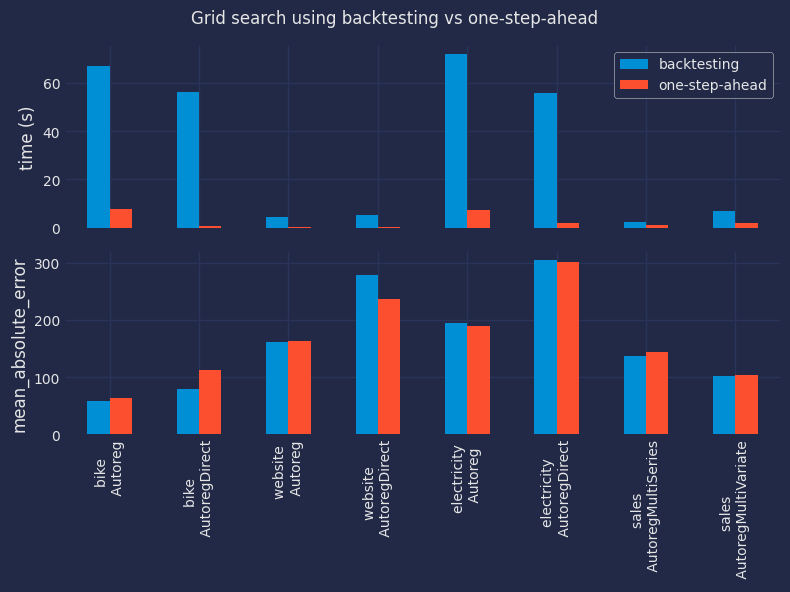

In [14]:
# Results
# ==============================================================================
summarize_results(
    results   = results_grid_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    title     = 'Grid search using backtesting vs one-step-ahead',
    save_plot = "../img/grid_search_benchmarck.png"
)

### Bayesian search

In [15]:
# Table to store results
# ==============================================================================
results_bayesian_search = []
metric = 'mean_absolute_error'

In [16]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection\model_selection.py:1741: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 134.78563737869263
Execution time one step ahead: 33.7517454624176
Same lags  : True
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.22858217381619642, 'reg_alpha': 0.23797728006705565, 'reg_lambda': 0.9887301767538854}
    mean_absolute_error: 55.80577702511616

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.22858217381619642, 'reg_alpha': 0.23797728006705565, 'reg_lambda': 0.9887301767538854}
    mean_absolute_error: 55.80577702511616


In [17]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection\model_selection.py:1741: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 16.788043975830078
Execution time one step ahead: 1.278191089630127
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 121.0898788312409}
    mean_absolute_error: 79.14983372140252

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 15.094374246471325}
    mean_absolute_error: 111.9620873402686


In [18]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 0.9480068683624268
Execution time one step ahead: 0.16192364692687988
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 136.76802274106473

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 173.52829988091955


c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection\model_selection.py:1741: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


In [19]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 7
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection\model_selection.py:1741: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 1.7894976139068604
Execution time one step ahead: 0.32030177116394043
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 139.40123604697365

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 153.6723680506675


In [20]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection\model_selection.py:1741: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 89.82653188705444
Execution time one step ahead: 25.719449043273926
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.020288327487155415, 'gamma': 0.9893221948178936, 'reg_alpha': 0.00267513077343301, 'reg_lambda': 0.0033431281459105205}
    mean_absolute_error: 196.74829952595292

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660213, 'reg_alpha': 0.24605588251007016, 'reg_lambda': 0.9687485406819448}
    mean_absolute_error: 191.37491441780287


In [21]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 24
             )

lags_grid = (48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169))

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection\model_selection.py:1741: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 14.482036828994751
Execution time one step ahead: 0.6556460857391357
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 16.432489069228232}
    mean_absolute_error: 307.1336527862061

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 0.36149961722510493}
    mean_absolute_error: 300.8702813315484


In [22]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = ['day_of_week']

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection_multiseries\model_selection_multiseries.py:2318: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


Benchmark results
-----------------
Execution time backtesting   : 4.395848989486694
Execution time one step ahead: 2.5986406803131104
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 74, 'max_depth': 8, 'learning_rate': 0.40420227800022523}
    187.83389755674088

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.06045266837878549}
    133.65427971719967


In [23]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)
results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection_multiseries\model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
c:\anaconda\envs\skforecast_14_p12\Lib\site-packages\skforecast\model_selection_multiseries\model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
c:\a

Benchmark results
-----------------
Execution time backtesting   : 19.077252626419067
Execution time one step ahead: 5.670187950134277
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 178, 'max_depth': 4, 'learning_rate': 0.029134647763314356}
    101.11360934325215

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 198, 'max_depth': 8, 'learning_rate': 0.11386606446550962}
    103.7747144410278


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,speed_up,dataset_forecaster
0,bike_sharing,ForecasterAutoreg,134.785637,33.751745,55.805777,55.805777,3.99,bike_sharing \n Autoreg
1,bike_sharing,ForecasterAutoregDirect,16.788044,1.278191,79.149834,111.962087,13.13,bike_sharing \n AutoregDirect
2,website,ForecasterAutoreg,0.948007,0.161924,136.768023,173.528300,5.85,website \n Autoreg
3,website,ForecasterAutoregDirect,1.789498,0.320302,139.401236,153.672368,5.59,website \n AutoregDirect
4,electricity,ForecasterAutoreg,89.826532,25.719449,196.748300,191.374914,3.49,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,14.482037,0.655646,307.133653,300.870281,22.09,electricity \n AutoregDirect
6,sales,ForecasterAutoregMultiSeries,4.395849,2.598641,187.833898,133.654280,1.69,sales \n AutoregMultiSeries
7,sales,ForecasterAutoregMultiVariate,19.077253,5.670188,101.113609,103.774714,3.36,sales \n AutoregMultiVariate


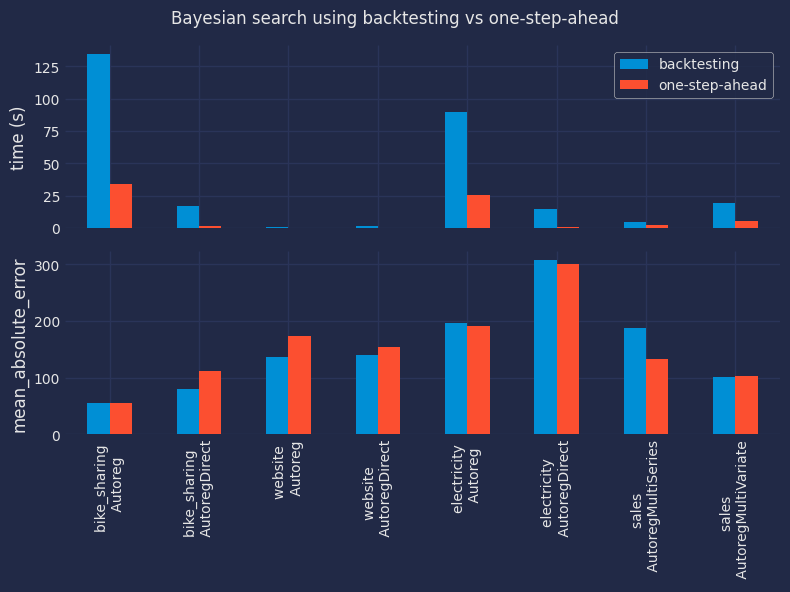

In [24]:
# Results
# ==============================================================================
summarize_results(
    results   = results_bayesian_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    title     = 'Bayesian search using backtesting vs one-step-ahead',
    save_plot = "../img/bayesian_search_benchmarck.png"
)